In [1]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
df_eleInfo = pd.read_csv("element_info.csv")
df_Hmix = pd.read_csv("DeltaHmix.tsv", sep=' ')
df_m = pd.read_csv("Miedema.csv")

In [7]:
import itertools

metals = ['Cu', 'Ag', 'Au', 'Pt', 'Pd', 'Al']
metal_combinations = itertools.combinations(metals, 2)
for i, j in metal_combinations:
    hmix = df_Hmix[((df_Hmix['A'] == i) & (df_Hmix['B'] == j)) | ((df_Hmix['A'] == j) & (df_Hmix['B'] == i))]['delta_Hf'].iloc[0]
    print(i, j, hmix)

Cu Ag 2.0
Cu Au -9.0
Cu Pt -12.0
Cu Pd -14.0
Cu Al -1.0
Ag Au -6.0
Ag Pt -1.0
Ag Pd -7.0
Ag Al -4.0
Au Pt 4.0
Au Pd 0.0
Au Al -22.0
Pt Pd 2.0
Pt Al -44.0
Pd Al -46.0


In [12]:
df_m[df_m['element'].isin(metals)][['element', 'melting_point']]

,element,melting_point
8,Al,933.25
21,Cu,1357.60
35,Pd,1825.00
36,Ag,1234.00
64,Pt,2045.00
65,Au,1337.58


In [4]:
import re
import math

def process_string(s):
    pattern = re.compile(r'([A-Z][a-z]*)(\d*\.?\d+)?')
    result_dict = {}
    for match in pattern.finditer(s):
        key = match.group(1)
        num = float(match.group(2)) if match.group(2) is not None else 1.0
        result_dict[key] = num
    return result_dict

def delta_A(data_dict, dataframe, A_attr, caltype=0):
    total_value = sum(data_dict.values())
    weighted_sum = 0
    sum_of_squares = 0
    A_values = []
    concentrations = []
    
    # Calculate the property value and concentration value of each element
    for key, value in data_dict.items():
        concentration = value / total_value
        row = dataframe[dataframe['Symbol'] == key]
        if not row.empty:
            A_value = row[A_attr].iloc[0]
            A_values.append(A_value)
            concentrations.append(concentration)
    
    # Calculate weighted sum
    for c, A in zip(concentrations, A_values):
        weighted_sum += c * A
    
    # Calculate the sum of squares, divided into two cases
    if caltype == 0:
        for c, A in zip(concentrations, A_values):
            sum_of_squares += c * ((1 - A / weighted_sum) ** 2)
    elif caltype == 1:
        for c, A in zip(concentrations, A_values):
            sum_of_squares += c * ((A - weighted_sum) ** 2) 
    
    # Calculate square root value
    delta_A = math.sqrt(sum_of_squares)
    return delta_A

def sigma_A(data_dict, dataframe, A_attr):
    total_value = sum(data_dict.values())
    sigma_A = 0
    for key, value in data_dict.items():
        concentration = value / total_value
        row = dataframe[dataframe['Symbol'] == key]
        if not row.empty:
            A_value = row[A_attr].iloc[0]
            sigma_A += concentration * A_value
    return sigma_A

def H_mix(data_dict, df):
    H_mix = 0
    total_value = sum(data_dict.values())
    for i, val1 in data_dict.items():
        for j, val2 in data_dict.items():
            if i != j:
                result = df[((df['A'] == i) & (df['B'] == j)) | ((df['A'] == j) & (df['B'] == i))]['delta_Hf']
                value = result.iloc[0] if not result.empty else None
                H_mix += 4*value*(val1/total_value)*(val2/total_value)
    # Because the same atom pair is counted twice
    return H_mix/2

def S_mix(data_dict):
    S_mix = 0
    total_value = sum(data_dict.values())
    for key, value in data_dict.items():
        concentration = value / total_value
        S_mix += concentration*math.log(concentration)
    return -8.314*S_mix
    

In [5]:
def judge_stable_phase(data_dict):

    delta_Hmix = H_mix(data_dict, df_Hmix)
    delta_Smix = S_mix(data_dict)
    delta_R = delta_A(data_dict, df_eleInfo, "Radius", caltype=0)*100
    delta_X = delta_A(data_dict, df_eleInfo, "X", caltype=1)
    VECmix = sigma_A(data_dict, df_eleInfo, "VEC")
    Tmix = sigma_A(data_dict, df_eleInfo, "melting_point")

    Omiga = Tmix*delta_Smix/1000/abs(delta_Hmix)

    cond1 = (-11.6 < delta_Hmix < 3.2)
    cond2 = (delta_R <= 6.6)
    cond3 = (Omiga >= 1.1)
    
    is_stable = False
    phase = None
    
    if cond2 and cond3:
    # if cond1 and cond2 and cond3:
        is_stable = True
        if VECmix >8:
            phase = 'FCC'
        elif VECmix < 6.87:
            phase = 'BCC'
        else:
            phase = 'Mix'
    
    return is_stable, phase

In [6]:
s = "CoCrFeNiCuAl0.5V0.2"
data_dict = process_string(s)
judge_stable_phase(data_dict)

(True, 'FCC')

Elements to be selected

In [7]:
from itertools import product
import numpy as np
from itertools import combinations

def generate_compositions(elements, n=5, total=100, min_val=5, max_val=35, step=5):
    groups = [range(min_val, max_val+step, step) for _ in range(n)]
    for selected_elements in combinations(elements, n):
        if 'Cu' not in selected_elements:
            continue
        for combination in product(*groups):
            if sum(combination) == total:
                yield dict(zip(selected_elements, np.array(combination)/100))

In [44]:
elements = {'Cu', 'Ag', 'Au', 'Pt', 'Pd', 'Al'}

count1 = 0
for i in generate_compositions(elements):
    count1 += 1
print(count1)

count2 = 0
for i in generate_compositions(elements, n=4):
    count2 += 1
print(count2)

count1+count2

7255
1490


8745

Writing to sqlite database

In [17]:
import sqlite3
from tqdm import tqdm
import json

# Connect to the SQLite database (create if it does not exist)
conn = sqlite3.connect('my_data_new.db')
c = conn.cursor()

# Create a new table (if it does not already exist)
_ = c.execute('''CREATE TABLE IF NOT EXISTS my_table 
              (data_dict TEXT, delta_Hmix REAL, delta_Smix REAL, delta_R REAL, VECmix REAL, Tmix REAL, Omiga REAL)''')

BATCH_SIZE = 1000 
batch_counter = 0

elements = {'Cu', 'Ag', 'Au', 'Pt', 'Pd', 'Al'}

count = 0
for i in generate_compositions(elements):
    count += 1
    
for data_dict in tqdm(generate_compositions(elements), total=count):
    
    for key, value in data_dict.items():
        data_dict[key] = round(value, 2)
    
    delta_Hmix = round(H_mix(data_dict, df_Hmix), 3)
    delta_Smix = round(S_mix(data_dict), 3)
    delta_R = round(delta_A(data_dict, df_eleInfo, "Radius", caltype=0)*100, 3)
    # delta_X = delta_A(data_dict, df_eleInfo, "X", caltype=1)
    VECmix = round(sigma_A(data_dict, df_eleInfo, "VEC"), 3)
    Tmix = round(sigma_A(data_dict, df_eleInfo, "melting_point"), 3)
    Omiga = round(Tmix*delta_Smix/1000/abs(delta_Hmix), 3)
    
    data_dict_json = json.dumps(data_dict)
    
    # Insert data without committing immediately
    _ = c.execute("INSERT INTO my_table (data_dict, delta_Hmix, delta_Smix, delta_R, VECmix, Tmix, Omiga) VALUES (?, ?, ?, ?, ?, ?, ?)", 
                  (data_dict_json, delta_Hmix, delta_Smix, delta_R, VECmix, Tmix, Omiga))

    
    batch_counter += 1
    if batch_counter >= BATCH_SIZE:
        conn.commit()  # Commit after every BATCH_SIZE records
        batch_counter = 0

# Commit any remaining records
if batch_counter > 0:
    conn.commit()


elements = {'Cu', 'Ag', 'Au', 'Pt', 'Pd', 'Al'}
count = 0
for i in generate_compositions(elements, n=4):
    count += 1
    
for data_dict in tqdm(generate_compositions(elements, n=4), total=count):
    
    for key, value in data_dict.items():
        data_dict[key] = round(value, 2)
    
    delta_Hmix = round(H_mix(data_dict, df_Hmix), 3)
    delta_Smix = round(S_mix(data_dict), 3)
    delta_R = round(delta_A(data_dict, df_eleInfo, "Radius", caltype=0)*100, 3)
    # delta_X = delta_A(data_dict, df_eleInfo, "X", caltype=1)
    VECmix = round(sigma_A(data_dict, df_eleInfo, "VEC"), 3)
    Tmix = round(sigma_A(data_dict, df_eleInfo, "melting_point"), 3)
    Omiga = round(Tmix*delta_Smix/1000/abs(delta_Hmix), 3)
    
    data_dict_json = json.dumps(data_dict)
    
    # Insert data without committing immediately
    _ = c.execute("INSERT INTO my_table (data_dict, delta_Hmix, delta_Smix, delta_R, VECmix, Tmix, Omiga) VALUES (?, ?, ?, ?, ?, ?, ?)", 
                  (data_dict_json, delta_Hmix, delta_Smix, delta_R, VECmix, Tmix, Omiga))

    
    batch_counter += 1
    if batch_counter >= BATCH_SIZE:
        conn.commit()  # Commit after every BATCH_SIZE records
        batch_counter = 0

# Commit any remaining records
if batch_counter > 0:
    conn.commit()
    
conn.close()

100%|██████████| 1490/1490 [00:13<00:00, 110.86it/s]


Read sqlite database to df

In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('my_data_new.db')

df = pd.read_sql_query("SELECT * FROM my_table", conn)


conn.close()

# Check the first few rows of the DataFrame
print(df.head())

total_memory_usage_bytes = df.memory_usage(deep=True).sum()
total_memory_usage_mb = total_memory_usage_bytes / (1024 ** 2)  # Convert bytes to MB
print("Total memory usage:", total_memory_usage_mb, "MB")


                                           data_dict  delta_Hmix  delta_Smix  \
0  {"Pd": 0.05, "Pt": 0.05, "Al": 0.2, "Ag": 0.35...       -6.38      11.277   
1  {"Pd": 0.05, "Pt": 0.05, "Al": 0.25, "Ag": 0.3...       -7.49      11.430   
2  {"Pd": 0.05, "Pt": 0.05, "Al": 0.25, "Ag": 0.3...       -7.46      11.430   
3  {"Pd": 0.05, "Pt": 0.05, "Al": 0.3, "Ag": 0.25...       -8.52      11.430   
4  {"Pd": 0.05, "Pt": 0.05, "Al": 0.3, "Ag": 0.3,...       -8.50      11.499   

   delta_R  VECmix      Tmix  Omiga  
0    5.461     9.3  1287.210  2.275  
1    5.425     8.9  1272.173  1.941  
2    5.232     8.9  1265.992  1.940  
3    5.388     8.5  1257.135  1.687  
4    5.199     8.5  1250.955  1.692  
Total memory usage: 1.3413829803466797 MB


In [2]:
df

,data_dict,delta_Hmix,delta_Smix,delta_R,VECmix,Tmix,Omiga
0,"{""Pd"": 0.05, ""Pt"": 0.05, ""Al"": 0.2, ""Ag"": 0.35...",-6.38,11.277,5.461,9.3,1287.210,2.275
1,"{""Pd"": 0.05, ""Pt"": 0.05, ""Al"": 0.25, ""Ag"": 0.3...",-7.49,11.430,5.425,8.9,1272.173,1.941
2,"{""Pd"": 0.05, ""Pt"": 0.05, ""Al"": 0.25, ""Ag"": 0.3...",-7.46,11.430,5.232,8.9,1265.992,1.940
3,"{""Pd"": 0.05, ""Pt"": 0.05, ""Al"": 0.3, ""Ag"": 0.25...",-8.52,11.430,5.388,8.5,1257.135,1.687
4,"{""Pd"": 0.05, ""Pt"": 0.05, ""Al"": 0.3, ""Ag"": 0.3,...",-8.50,11.499,5.199,8.5,1250.955,1.692
...,...,...,...,...,...,...,...
8740,"{""Al"": 0.35, ""Ag"": 0.35, ""Cu"": 0.05, ""Au"": 0.25}",-12.14,10.236,2.489,8.2,1160.812,0.979
8741,"{""Al"": 0.35, ""Ag"": 0.35, ""Cu"": 0.1, ""Au"": 0.2}",-10.38,10.700,3.423,8.2,1161.814,1.198
8742,"{""Al"": 0.35, ""Ag"": 0.35, ""Cu"": 0.15, ""Au"": 0.15}",-8.44,10.842,4.085,8.2,1162.814,1.494
8743,"{""Al"": 0.35, ""Ag"": 0.35, ""Cu"": 0.2, ""Au"": 0.1}",-6.32,10.700,4.593,8.2,1163.816,1.970


In [2]:
import pandas as pd

def judge_stable_phase(row):
    delta_Hmix = row['delta_Hmix']
    delta_R = row['delta_R']
    Omiga = row['Omiga']
    VECmix = row['VECmix']

    cond1 = (-11.6 < delta_Hmix < 3.2)
    cond2 = (delta_R <= 6.6)
    cond3 = (Omiga >= 1.1)
    
    is_stable = False
    phase = None
    
    if cond2 and cond3:
        is_stable = True
        if VECmix > 8:
            phase = 'FCC'
        elif VECmix < 6.87:
            phase = 'BCC'
        else:
            phase = 'Mix'
    
    return pd.Series([is_stable, phase])

# Apply a function to each row and create a new column
df[['is_stable', 'phase']] = df.apply(judge_stable_phase, axis=1)

print(df.head())

                                           data_dict  delta_Hmix  delta_Smix  \
0  {"Pd": 0.05, "Pt": 0.05, "Al": 0.2, "Ag": 0.35...       -6.38      11.277   
1  {"Pd": 0.05, "Pt": 0.05, "Al": 0.25, "Ag": 0.3...       -7.49      11.430   
2  {"Pd": 0.05, "Pt": 0.05, "Al": 0.25, "Ag": 0.3...       -7.46      11.430   
3  {"Pd": 0.05, "Pt": 0.05, "Al": 0.3, "Ag": 0.25...       -8.52      11.430   
4  {"Pd": 0.05, "Pt": 0.05, "Al": 0.3, "Ag": 0.3,...       -8.50      11.499   

   delta_R  VECmix      Tmix  Omiga  is_stable phase  
0    5.461     9.3  1287.210  2.275       True   FCC  
1    5.425     8.9  1272.173  1.941       True   FCC  
2    5.232     8.9  1265.992  1.940       True   FCC  
3    5.388     8.5  1257.135  1.687       True   FCC  
4    5.199     8.5  1250.955  1.692       True   FCC  


In [3]:
df.describe()

,delta_Hmix,delta_Smix,delta_R,VECmix,Tmix,Omiga
count,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000
mean,-15.067362,12.102618,4.257624,9.417038,1450.492922,1.759962
std,7.372262,0.688163,0.737620,0.929265,121.748652,5.676534
min,-38.890000,10.236000,2.440000,7.600000,1160.812000,0.407000
25%,-20.390000,11.635000,3.695000,8.600000,1360.245000,0.850000
50%,-14.460000,12.224000,4.379000,9.400000,1450.161000,1.195000
75%,-8.750000,12.582000,4.839000,10.350000,1540.119000,1.974000
max,0.490000,13.381000,5.680000,10.950000,1760.779000,443.520000


Stable phase write file

In [12]:
df[df['is_stable'] == True]['data_dict'].to_csv('stable_hea.csv', index=False, header=False)

In [18]:
import csv
import json

with open('stable_hea.csv', 'r') as csvfile:
    
    reader = csv.reader(csvfile)
    data_list = []
    for row in reader:
        data = json.loads(row[0])
        data_list.append(data)

type(data_list[0])

dict

Graphical analysis

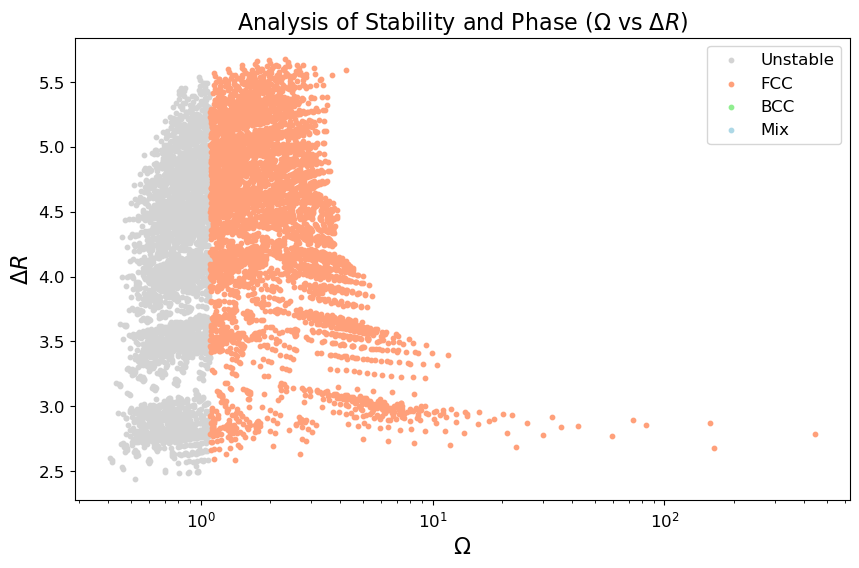

In [4]:
import matplotlib.pyplot as plt

stable_fcc = df[(df['is_stable'] == True) & (df['phase'] == 'FCC')]
stable_bcc = df[(df['is_stable'] == True) & (df['phase'] == 'BCC')]
stable_mix = df[(df['is_stable'] == True) & (df['phase'] == 'Mix')]
unstable = df[df['is_stable'] == False]

plt.figure(figsize=(10, 6))
s = 10
plt.scatter(unstable['Omiga'], unstable['delta_R'], color='lightgray', label='Unstable', s=s)
plt.scatter(stable_fcc['Omiga'], stable_fcc['delta_R'], color='lightsalmon', label='FCC', s=s)
plt.scatter(stable_bcc['Omiga'], stable_bcc['delta_R'], color='lightgreen', label='BCC', s=s)
plt.scatter(stable_mix['Omiga'], stable_mix['delta_R'], color='lightblue', label='Mix', s=s)

# def get_sample_type(data_dict):
#     num_keys = len(json.loads(data_dict))
#     return num_keys

# df_quaternary = df[(df['data_dict'].apply(get_sample_type) == 4) & (df['is_stable'] == True)]
# # df_quinary = df[df['data_dict'].apply(get_sample_type) == 5]
# plt.scatter(df_quaternary['Omiga'], df_quaternary['delta_R'], color='lightblue', s=s)

plt.legend()

plt.title('Analysis of Stability and Phase ($\Omega$ vs $\Delta R$)', fontsize=16)
plt.xlabel('$\Omega$', fontsize=16)
plt.ylabel('$\Delta R$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize='large') 

plt.xscale('log')

plt.show()

In [7]:
df[df['is_stable'] == True].to_csv("df_stable.csv")
df[df['is_stable'] == False].to_csv("df_unstable.csv")

In [46]:
phase_counts = df['is_stable'].value_counts()

print(phase_counts)

is_stable
True     4843
False    3902
Name: count, dtype: int64


Some other statistics

In [4]:
df = pd.read_csv("df_stable.csv", index_col=0)
df

,data_dict,delta_Hmix,delta_Smix,delta_R,VECmix,Tmix,Omiga,is_stable,phase
0,"{""Pd"": 0.05, ""Pt"": 0.05, ""Al"": 0.2, ""Ag"": 0.35...",-6.38,11.277,5.461,9.3,1287.210,2.275,True,FCC
1,"{""Pd"": 0.05, ""Pt"": 0.05, ""Al"": 0.25, ""Ag"": 0.3...",-7.49,11.430,5.425,8.9,1272.173,1.941,True,FCC
2,"{""Pd"": 0.05, ""Pt"": 0.05, ""Al"": 0.25, ""Ag"": 0.3...",-7.46,11.430,5.232,8.9,1265.992,1.940,True,FCC
3,"{""Pd"": 0.05, ""Pt"": 0.05, ""Al"": 0.3, ""Ag"": 0.25...",-8.52,11.430,5.388,8.5,1257.135,1.687,True,FCC
4,"{""Pd"": 0.05, ""Pt"": 0.05, ""Al"": 0.3, ""Ag"": 0.3,...",-8.50,11.499,5.199,8.5,1250.955,1.692,True,FCC
...,...,...,...,...,...,...,...,...,...
8739,"{""Al"": 0.35, ""Ag"": 0.3, ""Cu"": 0.3, ""Au"": 0.05}",-3.82,10.306,5.297,8.2,1170.996,3.159,True,FCC
8741,"{""Al"": 0.35, ""Ag"": 0.35, ""Cu"": 0.1, ""Au"": 0.2}",-10.38,10.700,3.423,8.2,1161.814,1.198,True,FCC
8742,"{""Al"": 0.35, ""Ag"": 0.35, ""Cu"": 0.15, ""Au"": 0.15}",-8.44,10.842,4.085,8.2,1162.814,1.494,True,FCC
8743,"{""Al"": 0.35, ""Ag"": 0.35, ""Cu"": 0.2, ""Au"": 0.1}",-6.32,10.700,4.593,8.2,1163.816,1.970,True,FCC


In [13]:
ave_ratio = {}
nums_count = {}

for row in df["data_dict"]:
    for key, val in eval(row).items():
        if key in ave_ratio:
            ave_ratio[key] += val
        else:
            ave_ratio[key] = val
        
        if key in nums_count:
            nums_count[key] += 1
        else:
            nums_count[key] = 1

for key, val in ave_ratio.items():
    ave_ratio[key] = round(ave_ratio[key] / 4843, 3)

ave_ratio

{'Pd': 0.15, 'Pt': 0.167, 'Al': 0.078, 'Ag': 0.205, 'Cu': 0.225, 'Au': 0.176}

In [16]:
nums_count

{'Pd': 3570, 'Pt': 3867, 'Al': 2796, 'Ag': 4296, 'Cu': 4843, 'Au': 3990}